<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [2]:
# %%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
# Build a Vocabulary
from collections import Counter

# Compute word frequencies for each word in captions. See code above for data structure
word_counts = Counter([token for img in captions for caption in img for token in caption[1:-1]])

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [10]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048,
                 n_layers=1, dropout=0):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(
            num_embeddings=n_tokens,
            embedding_dim=emb_size
        )
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=lstm_units,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=False,
            batch_first=True
        )
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(
            in_features=n_layers*lstm_units,
            out_features=n_tokens
        )
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix) # [batch, emb_size]
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, hidden = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [11]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [12]:
network = CaptionNet(n_tokens).to(device)

In [13]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec.to(device), dummy_capt_ix.to(device)).cpu()

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [14]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)

In [15]:
def compute_loss(network, image_vectors, captions_ix, criterion=criterion):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous().view(-1)
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors.to(device), captions_ix_inp.to(device)).cpu()
    logits_for_next = logits_for_next.contiguous().view(-1, logits_for_next.shape[-1])
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = criterion(logits_for_next, captions_ix_next)
    
    return loss

In [16]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

# assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.item() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [17]:
params = [param for param in network.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(params, lr=3e-4, amsgrad=True, weight_decay=1e-6)

# Training

* First implement the batch generator
* Than train the network as usual

In [18]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [19]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [20]:
generate_batch(img_codes,captions,3)

(tensor([[0.8304, 0.0657, 0.4276,  ..., 0.3166, 0.6607, 1.6752],
         [0.9149, 0.0814, 1.0381,  ..., 0.0299, 0.4347, 1.3345],
         [0.1836, 0.4968, 0.7774,  ..., 0.0115, 0.2842, 0.4703]]),
 tensor([[   1,  112,  143, 1285,  559,  185,    6,   24,  958,   12,    2,    3,
             3,    3],
         [   1, 4309,  443, 1932,   35, 1929,   10,  278,  576,   35, 4589,    0,
            12,    2],
         [   1,   88,  403,  140,   35,   77,   14,  599, 1369,   12,    2,    3,
             3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [21]:
batch_size = 50  # adjust me
n_epochs = 300  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [22]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        optimizer.zero_grad()
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 1)
        
        optimizer.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    with torch.no_grad():
        for _ in range(n_validation_batches):
            loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
            val_loss += loss_t.item()
        val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

  4%|▍         | 2/50 [00:00<00:03, 13.24it/s]


Epoch: 0, train loss: 7.475371522903442, val loss: 5.5310437202453615


  2%|▏         | 1/50 [00:00<00:05,  8.97it/s]


Epoch: 1, train loss: 5.126978225708008, val loss: 4.966923236846924


  4%|▍         | 2/50 [00:00<00:03, 13.03it/s]


Epoch: 2, train loss: 4.888442831039429, val loss: 4.807728385925293


  4%|▍         | 2/50 [00:00<00:04, 11.35it/s]


Epoch: 3, train loss: 4.753758811950684, val loss: 4.833530521392822


  2%|▏         | 1/50 [00:00<00:05,  9.78it/s]


Epoch: 4, train loss: 4.643711404800415, val loss: 4.582147026062012


  4%|▍         | 2/50 [00:00<00:04, 10.44it/s]


Epoch: 5, train loss: 4.5495969581604, val loss: 4.454685020446777


  4%|▍         | 2/50 [00:00<00:03, 14.92it/s]


Epoch: 6, train loss: 4.447535381317139, val loss: 4.328100109100342


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.364899110794068, val loss: 4.347441101074219


  4%|▍         | 2/50 [00:00<00:04, 11.95it/s]


Epoch: 8, train loss: 4.3226673030853275, val loss: 4.227695369720459


  4%|▍         | 2/50 [00:00<00:04, 11.68it/s]


Epoch: 9, train loss: 4.2415256547927855, val loss: 4.314009475708008


  2%|▏         | 1/50 [00:00<00:05,  9.13it/s]


Epoch: 10, train loss: 4.1919150018692015, val loss: 4.122974300384522


  4%|▍         | 2/50 [00:00<00:04, 11.84it/s]


Epoch: 11, train loss: 4.143614358901978, val loss: 4.076686573028565


  4%|▍         | 2/50 [00:00<00:04, 11.11it/s]


Epoch: 12, train loss: 4.0851944637298585, val loss: 4.109652948379517


  4%|▍         | 2/50 [00:00<00:03, 12.18it/s]


Epoch: 13, train loss: 4.043858771324158, val loss: 4.042742490768433


  4%|▍         | 2/50 [00:00<00:02, 17.01it/s]


Epoch: 14, train loss: 4.034342365264893, val loss: 4.014474248886108


  2%|▏         | 1/50 [00:00<00:06,  7.03it/s]


Epoch: 15, train loss: 3.956499981880188, val loss: 3.9830347537994384


  4%|▍         | 2/50 [00:00<00:04, 11.11it/s]


Epoch: 16, train loss: 3.913456516265869, val loss: 3.994209861755371


  4%|▍         | 2/50 [00:00<00:03, 13.33it/s]


Epoch: 17, train loss: 3.9170575189590453, val loss: 3.8933270931243897


  2%|▏         | 1/50 [00:00<00:04,  9.92it/s]


Epoch: 18, train loss: 3.8261289596557617, val loss: 3.862482213973999


  4%|▍         | 2/50 [00:00<00:03, 12.79it/s]


Epoch: 19, train loss: 3.832720408439636, val loss: 3.885344409942627


  4%|▍         | 2/50 [00:00<00:04, 11.77it/s]


Epoch: 20, train loss: 3.8023121404647826, val loss: 3.833990526199341


  2%|▏         | 1/50 [00:00<00:05,  9.39it/s]


Epoch: 21, train loss: 3.7468429613113403, val loss: 3.7674917221069335


  4%|▍         | 2/50 [00:00<00:03, 12.02it/s]


Epoch: 22, train loss: 3.728980178833008, val loss: 3.6729952812194826


  4%|▍         | 2/50 [00:00<00:02, 16.87it/s]


Epoch: 23, train loss: 3.680451774597168, val loss: 3.6131114959716797


  4%|▍         | 2/50 [00:00<00:04, 11.70it/s]


Epoch: 24, train loss: 3.649397306442261, val loss: 3.807383728027344


  4%|▍         | 2/50 [00:00<00:03, 12.44it/s]


Epoch: 25, train loss: 3.622361907958984, val loss: 3.6254765510559084


  4%|▍         | 2/50 [00:00<00:03, 13.19it/s]


Epoch: 26, train loss: 3.645265293121338, val loss: 3.5694766998291017


  4%|▍         | 2/50 [00:00<00:04, 11.12it/s]


Epoch: 27, train loss: 3.597270703315735, val loss: 3.6050304412841796


  4%|▍         | 2/50 [00:00<00:04, 10.82it/s]


Epoch: 28, train loss: 3.5783103561401366, val loss: 3.6138811111450195


  4%|▍         | 2/50 [00:00<00:04, 11.25it/s]


Epoch: 29, train loss: 3.584595355987549, val loss: 3.5690905094146728


  4%|▍         | 2/50 [00:00<00:04, 11.88it/s]


Epoch: 30, train loss: 3.5510785818099975, val loss: 3.4992696762084963


  2%|▏         | 1/50 [00:00<00:04,  9.89it/s]


Epoch: 31, train loss: 3.522910394668579, val loss: 3.4917104244232178


  4%|▍         | 2/50 [00:00<00:03, 12.62it/s]


Epoch: 32, train loss: 3.4828277349472048, val loss: 3.580333137512207


  4%|▍         | 2/50 [00:00<00:03, 13.57it/s]


Epoch: 33, train loss: 3.447875828742981, val loss: 3.407385158538818


  2%|▏         | 1/50 [00:00<00:04,  9.82it/s]


Epoch: 34, train loss: 3.429917516708374, val loss: 3.4004273891448973


  2%|▏         | 1/50 [00:00<00:07,  6.74it/s]


Epoch: 35, train loss: 3.408175129890442, val loss: 3.457440185546875


  2%|▏         | 1/50 [00:00<00:06,  7.92it/s]


Epoch: 36, train loss: 3.40880850315094, val loss: 3.482767915725708


  2%|▏         | 1/50 [00:00<00:05,  9.46it/s]


Epoch: 37, train loss: 3.3951983737945555, val loss: 3.4869689464569094


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 3.3616579008102416, val loss: 3.485157537460327


  2%|▏         | 1/50 [00:00<00:04,  9.91it/s]


Epoch: 39, train loss: 3.350689787864685, val loss: 3.4246890544891357


  4%|▍         | 2/50 [00:00<00:03, 12.13it/s]


Epoch: 40, train loss: 3.377113699913025, val loss: 3.462713670730591


  4%|▍         | 2/50 [00:00<00:04, 10.54it/s]


Epoch: 41, train loss: 3.3642717838287353, val loss: 3.4089722633361816


  4%|▍         | 2/50 [00:00<00:03, 14.44it/s]


Epoch: 42, train loss: 3.3238027334213256, val loss: 3.4997285842895507


  4%|▍         | 2/50 [00:00<00:04, 11.69it/s]


Epoch: 43, train loss: 3.299083876609802, val loss: 3.3076470375061033


  2%|▏         | 1/50 [00:00<00:05,  9.47it/s]


Epoch: 44, train loss: 3.2627604579925538, val loss: 3.3682723522186278


  4%|▍         | 2/50 [00:00<00:04, 11.13it/s]


Epoch: 45, train loss: 3.2987473726272585, val loss: 3.2992127895355225


  4%|▍         | 2/50 [00:00<00:03, 14.36it/s]


Epoch: 46, train loss: 3.2303743410110473, val loss: 3.188226270675659


  2%|▏         | 1/50 [00:00<00:05,  8.70it/s]


Epoch: 47, train loss: 3.24536340713501, val loss: 3.2173625469207763


  2%|▏         | 1/50 [00:00<00:06,  7.61it/s]


Epoch: 48, train loss: 3.241616168022156, val loss: 3.2533671855926514


  4%|▍         | 2/50 [00:00<00:03, 12.03it/s]


Epoch: 49, train loss: 3.214344129562378, val loss: 3.2468759536743166


  4%|▍         | 2/50 [00:00<00:03, 12.58it/s]


Epoch: 50, train loss: 3.2296193742752077, val loss: 3.159564161300659


  2%|▏         | 1/50 [00:00<00:05,  9.62it/s]


Epoch: 51, train loss: 3.252518835067749, val loss: 3.3425652027130126


  2%|▏         | 1/50 [00:00<00:05,  9.41it/s]


Epoch: 52, train loss: 3.188531765937805, val loss: 3.3399936676025392


  4%|▍         | 2/50 [00:00<00:04, 10.51it/s]


Epoch: 53, train loss: 3.207994022369385, val loss: 3.216878890991211


  4%|▍         | 2/50 [00:00<00:04, 11.99it/s]


Epoch: 54, train loss: 3.1964106035232542, val loss: 3.1744007110595702


  4%|▍         | 2/50 [00:00<00:03, 12.34it/s]


Epoch: 55, train loss: 3.1887597465515136, val loss: 3.2647517681121827


  2%|▏         | 1/50 [00:00<00:05,  8.24it/s]


Epoch: 56, train loss: 3.165106716156006, val loss: 3.1453816890716553


  2%|▏         | 1/50 [00:00<00:05,  8.35it/s]


Epoch: 57, train loss: 3.1634496307373046, val loss: 3.077378988265991


  4%|▍         | 2/50 [00:00<00:03, 13.48it/s]


Epoch: 58, train loss: 3.152868037223816, val loss: 3.2109778881073


  4%|▍         | 2/50 [00:00<00:03, 13.41it/s]


Epoch: 59, train loss: 3.1041472434997557, val loss: 3.067746067047119


  2%|▏         | 1/50 [00:00<00:04,  9.98it/s]


Epoch: 60, train loss: 3.1043577194213867, val loss: 3.1611603260040284


  4%|▍         | 2/50 [00:00<00:03, 12.82it/s]


Epoch: 61, train loss: 3.148478136062622, val loss: 3.2160835742950438


  4%|▍         | 2/50 [00:00<00:04, 11.33it/s]


Epoch: 62, train loss: 3.127227258682251, val loss: 3.131243276596069


  4%|▍         | 2/50 [00:00<00:03, 13.11it/s]


Epoch: 63, train loss: 3.133161339759827, val loss: 3.101986360549927


  2%|▏         | 1/50 [00:00<00:06,  8.05it/s]


Epoch: 64, train loss: 3.095751190185547, val loss: 3.1260345935821534


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 3.115685715675354, val loss: 3.036424160003662


  4%|▍         | 2/50 [00:00<00:04, 11.65it/s]


Epoch: 66, train loss: 3.1224883794784546, val loss: 3.1948908805847167


  4%|▍         | 2/50 [00:00<00:03, 14.18it/s]


Epoch: 67, train loss: 3.1163988590240477, val loss: 3.036974382400513


  4%|▍         | 2/50 [00:00<00:03, 12.71it/s]


Epoch: 68, train loss: 3.053953766822815, val loss: 3.0265734672546385


  4%|▍         | 2/50 [00:00<00:04, 10.92it/s]


Epoch: 69, train loss: 3.105652289390564, val loss: 3.0998886108398436


  4%|▍         | 2/50 [00:00<00:03, 13.79it/s]


Epoch: 70, train loss: 3.079692850112915, val loss: 3.132264423370361


  2%|▏         | 1/50 [00:00<00:05,  8.47it/s]


Epoch: 71, train loss: 3.0156609916687014, val loss: 3.1136855602264406


  4%|▍         | 2/50 [00:00<00:03, 12.01it/s]


Epoch: 72, train loss: 3.070758972167969, val loss: 3.170820188522339


  2%|▏         | 1/50 [00:00<00:05,  9.75it/s]


Epoch: 73, train loss: 3.0313080024719237, val loss: 3.1777493476867678


  4%|▍         | 2/50 [00:00<00:03, 13.41it/s]


Epoch: 74, train loss: 3.067613916397095, val loss: 2.9634912967681886


  4%|▍         | 2/50 [00:00<00:04, 11.94it/s]


Epoch: 75, train loss: 3.037693305015564, val loss: 3.104737377166748


  4%|▍         | 2/50 [00:00<00:04, 10.71it/s]


Epoch: 76, train loss: 3.0359901142120362, val loss: 3.1456913471221926


  4%|▍         | 2/50 [00:00<00:03, 15.01it/s]


Epoch: 77, train loss: 3.0164366483688356, val loss: 3.0682427883148193


  4%|▍         | 2/50 [00:00<00:03, 12.34it/s]


Epoch: 78, train loss: 2.959519696235657, val loss: 3.077820634841919


  4%|▍         | 2/50 [00:00<00:04, 11.67it/s]


Epoch: 79, train loss: 3.0358812046051025, val loss: 2.908556604385376


  4%|▍         | 2/50 [00:00<00:04, 11.10it/s]


Epoch: 80, train loss: 3.0275328397750854, val loss: 3.1035485744476317


  4%|▍         | 2/50 [00:00<00:03, 15.23it/s]


Epoch: 81, train loss: 2.9788319301605224, val loss: 3.023461103439331


  4%|▍         | 2/50 [00:00<00:03, 12.15it/s]


Epoch: 82, train loss: 3.0426758193969725, val loss: 2.9160370349884035


  4%|▍         | 2/50 [00:00<00:03, 13.69it/s]


Epoch: 83, train loss: 2.9802153301239014, val loss: 3.065988540649414


  4%|▍         | 2/50 [00:00<00:04, 11.19it/s]


Epoch: 84, train loss: 2.980848503112793, val loss: 3.0430601119995115


  2%|▏         | 1/50 [00:00<00:06,  8.05it/s]


Epoch: 85, train loss: 2.975099654197693, val loss: 3.0325458526611326


  4%|▍         | 2/50 [00:00<00:03, 12.04it/s]


Epoch: 86, train loss: 2.993166708946228, val loss: 2.9183875560760497


  4%|▍         | 2/50 [00:00<00:04, 11.66it/s]


Epoch: 87, train loss: 2.9713795614242553, val loss: 2.961458921432495


  4%|▍         | 2/50 [00:00<00:04, 11.78it/s]


Epoch: 88, train loss: 2.9309765100479126, val loss: 2.900287055969238


  4%|▍         | 2/50 [00:00<00:03, 13.04it/s]


Epoch: 89, train loss: 2.944101037979126, val loss: 3.0064242362976072


  6%|▌         | 3/50 [00:00<00:03, 15.17it/s]


Epoch: 90, train loss: 2.94539005279541, val loss: 2.95690655708313


  4%|▍         | 2/50 [00:00<00:03, 13.75it/s]


Epoch: 91, train loss: 2.901687488555908, val loss: 3.0297682762145994


  4%|▍         | 2/50 [00:00<00:02, 18.31it/s]


Epoch: 92, train loss: 2.9570960521698, val loss: 2.8144842624664306


  4%|▍         | 2/50 [00:00<00:04, 11.01it/s]


Epoch: 93, train loss: 2.9546505498886106, val loss: 3.0108341217041015


  4%|▍         | 2/50 [00:00<00:03, 13.00it/s]


Epoch: 94, train loss: 2.924577383995056, val loss: 2.936230945587158


  2%|▏         | 1/50 [00:00<00:05,  9.79it/s]


Epoch: 95, train loss: 2.9245467615127563, val loss: 3.057445192337036


  4%|▍         | 2/50 [00:00<00:04, 11.89it/s]


Epoch: 96, train loss: 2.9319868183135984, val loss: 2.9069200992584228


  4%|▍         | 2/50 [00:00<00:03, 12.70it/s]


Epoch: 97, train loss: 2.8979107475280763, val loss: 3.035760450363159


  4%|▍         | 2/50 [00:00<00:04, 11.32it/s]


Epoch: 98, train loss: 2.936218342781067, val loss: 3.0139376640319826


  2%|▏         | 1/50 [00:00<00:05,  9.15it/s]


Epoch: 99, train loss: 2.949883236885071, val loss: 2.8704723358154296


  4%|▍         | 2/50 [00:00<00:04, 10.25it/s]


Epoch: 100, train loss: 2.9214001274108887, val loss: 2.956537199020386


  4%|▍         | 2/50 [00:00<00:04, 10.19it/s]


Epoch: 101, train loss: 2.9704433393478396, val loss: 2.850291299819946


  4%|▍         | 2/50 [00:00<00:04, 10.93it/s]


Epoch: 102, train loss: 2.8965179347991943, val loss: 2.94552903175354


  4%|▍         | 2/50 [00:00<00:03, 13.22it/s]


Epoch: 103, train loss: 2.9042978715896606, val loss: 2.893370532989502


  2%|▏         | 1/50 [00:00<00:05,  9.28it/s]


Epoch: 104, train loss: 2.872112579345703, val loss: 2.7854523181915285


  2%|▏         | 1/50 [00:00<00:06,  8.06it/s]


Epoch: 105, train loss: 2.913468360900879, val loss: 2.9535215377807615


  4%|▍         | 2/50 [00:00<00:03, 12.75it/s]


Epoch: 106, train loss: 2.9004919958114623, val loss: 3.050211477279663


  4%|▍         | 2/50 [00:00<00:04, 11.39it/s]


Epoch: 107, train loss: 2.868960018157959, val loss: 2.940001630783081


  4%|▍         | 2/50 [00:00<00:03, 12.59it/s]


Epoch: 108, train loss: 2.8603391218185426, val loss: 2.938508701324463


  4%|▍         | 2/50 [00:00<00:04, 10.29it/s]


Epoch: 109, train loss: 2.852811460494995, val loss: 2.9718507289886475


  4%|▍         | 2/50 [00:00<00:04, 11.74it/s]


Epoch: 110, train loss: 2.897906346321106, val loss: 2.829890584945679


  4%|▍         | 2/50 [00:00<00:04, 11.62it/s]


Epoch: 111, train loss: 2.8770469331741335, val loss: 2.826917314529419


  4%|▍         | 2/50 [00:00<00:03, 15.10it/s]


Epoch: 112, train loss: 2.9095560836791994, val loss: 2.8034427642822264


  2%|▏         | 1/50 [00:00<00:05,  8.86it/s]


Epoch: 113, train loss: 2.8669314908981325, val loss: 2.889193868637085


  4%|▍         | 2/50 [00:00<00:04, 11.71it/s]


Epoch: 114, train loss: 2.8351117610931396, val loss: 2.7413761138916017


  4%|▍         | 2/50 [00:00<00:03, 12.00it/s]


Epoch: 115, train loss: 2.8633461141586305, val loss: 2.9510426998138426


  4%|▍         | 2/50 [00:00<00:03, 12.65it/s]


Epoch: 116, train loss: 2.8809434747695923, val loss: 2.7879469871520994


  4%|▍         | 2/50 [00:00<00:04, 10.14it/s]


Epoch: 117, train loss: 2.875581212043762, val loss: 2.863190793991089


  4%|▍         | 2/50 [00:00<00:03, 14.20it/s]


Epoch: 118, train loss: 2.865080738067627, val loss: 2.7728171348571777


  4%|▍         | 2/50 [00:00<00:03, 12.03it/s]


Epoch: 119, train loss: 2.83581045627594, val loss: 2.975310277938843


  4%|▍         | 2/50 [00:00<00:03, 12.02it/s]


Epoch: 120, train loss: 2.8776603031158445, val loss: 2.89579553604126


  4%|▍         | 2/50 [00:00<00:03, 15.97it/s]


Epoch: 121, train loss: 2.844162149429321, val loss: 2.9538864135742187


  2%|▏         | 1/50 [00:00<00:05,  9.70it/s]


Epoch: 122, train loss: 2.8380335712432863, val loss: 2.9247615814208983


  4%|▍         | 2/50 [00:00<00:04, 11.48it/s]


Epoch: 123, train loss: 2.8412375688552856, val loss: 2.8967820167541505


  2%|▏         | 1/50 [00:00<00:05,  9.16it/s]


Epoch: 124, train loss: 2.850692934989929, val loss: 2.880031681060791


  4%|▍         | 2/50 [00:00<00:04, 11.54it/s]


Epoch: 125, train loss: 2.839866347312927, val loss: 3.0643877029418944


  4%|▍         | 2/50 [00:00<00:04, 10.58it/s]


Epoch: 126, train loss: 2.849465489387512, val loss: 2.8707762241363524


  4%|▍         | 2/50 [00:00<00:03, 12.39it/s]


Epoch: 127, train loss: 2.8466825008392336, val loss: 2.689656686782837


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 128, train loss: 2.8008007335662843, val loss: 2.827205181121826


  4%|▍         | 2/50 [00:00<00:03, 12.96it/s]


Epoch: 129, train loss: 2.836909475326538, val loss: 2.9026296615600584


  4%|▍         | 2/50 [00:00<00:02, 17.92it/s]


Epoch: 130, train loss: 2.860957269668579, val loss: 2.8459290981292726


  4%|▍         | 2/50 [00:00<00:02, 16.49it/s]


Epoch: 131, train loss: 2.8243363428115846, val loss: 2.7748114585876467


  2%|▏         | 1/50 [00:00<00:06,  8.15it/s]


Epoch: 132, train loss: 2.8229875993728637, val loss: 2.9395830154418947


  4%|▍         | 2/50 [00:00<00:04, 11.16it/s]


Epoch: 133, train loss: 2.7993423891067506, val loss: 2.810693359375


  2%|▏         | 1/50 [00:00<00:05,  9.06it/s]


Epoch: 134, train loss: 2.813948655128479, val loss: 2.906080484390259


  2%|▏         | 1/50 [00:00<00:04,  9.94it/s]


Epoch: 135, train loss: 2.8121630716323853, val loss: 2.794507455825806


  2%|▏         | 1/50 [00:00<00:05,  8.99it/s]


Epoch: 136, train loss: 2.7752264022827147, val loss: 2.760375165939331


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 137, train loss: 2.7710293197631835, val loss: 2.898472023010254


  4%|▍         | 2/50 [00:00<00:04, 11.50it/s]


Epoch: 138, train loss: 2.784284906387329, val loss: 2.8192453384399414


  4%|▍         | 2/50 [00:00<00:03, 12.01it/s]


Epoch: 139, train loss: 2.7741891050338747, val loss: 2.7592689037322997


  4%|▍         | 2/50 [00:00<00:03, 12.33it/s]


Epoch: 140, train loss: 2.7957050657272338, val loss: 2.914110469818115


  2%|▏         | 1/50 [00:00<00:05,  8.76it/s]


Epoch: 141, train loss: 2.823340735435486, val loss: 2.7634105682373047


  4%|▍         | 2/50 [00:00<00:04, 11.49it/s]


Epoch: 142, train loss: 2.7697310495376586, val loss: 2.894433832168579


  4%|▍         | 2/50 [00:00<00:03, 14.63it/s]


Epoch: 143, train loss: 2.7802167320251465, val loss: 2.7786706924438476


  4%|▍         | 2/50 [00:00<00:03, 12.11it/s]


Epoch: 144, train loss: 2.8057385969161985, val loss: 2.8522348403930664


  4%|▍         | 2/50 [00:00<00:03, 12.68it/s]


Epoch: 145, train loss: 2.8089457321166993, val loss: 2.781830310821533


  4%|▍         | 2/50 [00:00<00:03, 12.27it/s]


Epoch: 146, train loss: 2.799689612388611, val loss: 2.749759149551392


  2%|▏         | 1/50 [00:00<00:05,  9.51it/s]


Epoch: 147, train loss: 2.7429125833511354, val loss: 2.8035969734191895


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 148, train loss: 2.7834579277038576, val loss: 2.722316598892212


  4%|▍         | 2/50 [00:00<00:03, 12.12it/s]


Epoch: 149, train loss: 2.7923867464065553, val loss: 2.834538459777832


  4%|▍         | 2/50 [00:00<00:03, 12.51it/s]


Epoch: 150, train loss: 2.746333050727844, val loss: 2.834656095504761


  4%|▍         | 2/50 [00:00<00:04, 11.56it/s]


Epoch: 151, train loss: 2.7650870418548585, val loss: 2.8452685832977296


  2%|▏         | 1/50 [00:00<00:05,  9.75it/s]


Epoch: 152, train loss: 2.7864843130111696, val loss: 2.8333805084228514


  4%|▍         | 2/50 [00:00<00:04, 11.34it/s]


Epoch: 153, train loss: 2.755663080215454, val loss: 2.797321844100952


  4%|▍         | 2/50 [00:00<00:03, 13.36it/s]


Epoch: 154, train loss: 2.743702073097229, val loss: 2.787547397613525


  4%|▍         | 2/50 [00:00<00:04, 11.32it/s]


Epoch: 155, train loss: 2.77088969707489, val loss: 2.7315229892730715


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 156, train loss: 2.768071160316467, val loss: 2.7762804985046388


  4%|▍         | 2/50 [00:00<00:04, 10.74it/s]


Epoch: 157, train loss: 2.745493154525757, val loss: 2.824680280685425


  4%|▍         | 2/50 [00:00<00:04, 10.37it/s]


Epoch: 158, train loss: 2.7767324924468992, val loss: 2.8712056636810304


  4%|▍         | 2/50 [00:00<00:03, 13.12it/s]


Epoch: 159, train loss: 2.7199350881576536, val loss: 2.686303949356079


  4%|▍         | 2/50 [00:00<00:04, 11.32it/s]


Epoch: 160, train loss: 2.741697812080383, val loss: 2.849073648452759


  4%|▍         | 2/50 [00:00<00:02, 18.66it/s]


Epoch: 161, train loss: 2.7655203342437744, val loss: 2.827698993682861


  4%|▍         | 2/50 [00:00<00:04, 10.86it/s]


Epoch: 162, train loss: 2.7428633260726927, val loss: 2.802547311782837


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 163, train loss: 2.7699459314346315, val loss: 2.723971128463745


  2%|▏         | 1/50 [00:00<00:05,  9.02it/s]


Epoch: 164, train loss: 2.7653020143508913, val loss: 2.7619005680084228


  4%|▍         | 2/50 [00:00<00:04, 11.60it/s]


Epoch: 165, train loss: 2.746319236755371, val loss: 2.74298677444458


  4%|▍         | 2/50 [00:00<00:03, 13.05it/s]


Epoch: 166, train loss: 2.718727583885193, val loss: 2.902762699127197


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 167, train loss: 2.7498901653289796, val loss: 2.8211904048919676


  4%|▍         | 2/50 [00:00<00:03, 12.46it/s]


Epoch: 168, train loss: 2.727819142341614, val loss: 2.8083027362823487


  4%|▍         | 2/50 [00:00<00:04, 11.09it/s]


Epoch: 169, train loss: 2.7253878593444822, val loss: 2.805909824371338


  4%|▍         | 2/50 [00:00<00:03, 12.03it/s]


Epoch: 170, train loss: 2.74523295879364, val loss: 2.7095853805541994


  2%|▏         | 1/50 [00:00<00:05,  8.48it/s]


Epoch: 171, train loss: 2.7553499269485475, val loss: 2.853599214553833


  4%|▍         | 2/50 [00:00<00:03, 15.75it/s]


Epoch: 172, train loss: 2.7816293478012084, val loss: 2.728469133377075


  4%|▍         | 2/50 [00:00<00:04, 10.82it/s]


Epoch: 173, train loss: 2.7159170579910277, val loss: 2.8389214515686034


  4%|▍         | 2/50 [00:00<00:03, 13.29it/s]


Epoch: 174, train loss: 2.673065867424011, val loss: 2.578513336181641


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 175, train loss: 2.696638822555542, val loss: 2.7771059036254884


  4%|▍         | 2/50 [00:00<00:04, 11.98it/s]


Epoch: 176, train loss: 2.709547610282898, val loss: 2.8638389110565186


  4%|▍         | 2/50 [00:00<00:04, 11.54it/s]


Epoch: 177, train loss: 2.774971590042114, val loss: 2.7678418159484863


  4%|▍         | 2/50 [00:00<00:04, 11.17it/s]


Epoch: 178, train loss: 2.7120922994613648, val loss: 2.790992259979248


  2%|▏         | 1/50 [00:00<00:05,  8.76it/s]


Epoch: 179, train loss: 2.702332363128662, val loss: 2.6062940120697022


  4%|▍         | 2/50 [00:00<00:04, 10.79it/s]


Epoch: 180, train loss: 2.7008453893661497, val loss: 2.753691577911377


  4%|▍         | 2/50 [00:00<00:03, 14.23it/s]


Epoch: 181, train loss: 2.7403400564193725, val loss: 2.830297517776489


  4%|▍         | 2/50 [00:00<00:02, 16.38it/s]


Epoch: 182, train loss: 2.720093288421631, val loss: 2.785031223297119


  2%|▏         | 1/50 [00:00<00:04,  9.93it/s]


Epoch: 183, train loss: 2.710886764526367, val loss: 2.8034667491912844


  2%|▏         | 1/50 [00:00<00:05,  9.02it/s]


Epoch: 184, train loss: 2.7411023950576783, val loss: 2.70265588760376


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 185, train loss: 2.67923921585083, val loss: 2.6530526638031007


  4%|▍         | 2/50 [00:00<00:04, 10.86it/s]


Epoch: 186, train loss: 2.6749297428131102, val loss: 2.7374083518981935


  4%|▍         | 2/50 [00:00<00:02, 19.78it/s]


Epoch: 187, train loss: 2.6883914852142334, val loss: 2.6661219596862793


  4%|▍         | 2/50 [00:00<00:03, 12.77it/s]


Epoch: 188, train loss: 2.6807400941848756, val loss: 2.7281476974487306


  4%|▍         | 2/50 [00:00<00:02, 17.05it/s]


Epoch: 189, train loss: 2.6792709589004517, val loss: 2.6427688598632812


  2%|▏         | 1/50 [00:00<00:05,  9.78it/s]


Epoch: 190, train loss: 2.715955023765564, val loss: 2.677495574951172


  4%|▍         | 2/50 [00:00<00:04, 11.40it/s]


Epoch: 191, train loss: 2.716006245613098, val loss: 2.6823288917541506


  4%|▍         | 2/50 [00:00<00:03, 12.95it/s]


Epoch: 192, train loss: 2.7178151178359986, val loss: 2.826257085800171


  4%|▍         | 2/50 [00:00<00:03, 12.78it/s]


Epoch: 193, train loss: 2.689477844238281, val loss: 2.7546128749847414


  4%|▍         | 2/50 [00:00<00:03, 12.92it/s]


Epoch: 194, train loss: 2.6925760602951048, val loss: 2.6960628986358643


  2%|▏         | 1/50 [00:00<00:05,  9.52it/s]


Epoch: 195, train loss: 2.7445632791519166, val loss: 2.7672262668609617


  4%|▍         | 2/50 [00:00<00:04, 10.85it/s]


Epoch: 196, train loss: 2.7028383779525758, val loss: 2.6992504596710205


  2%|▏         | 1/50 [00:00<00:05,  9.34it/s]


Epoch: 197, train loss: 2.6910619592666625, val loss: 2.652808666229248


  4%|▍         | 2/50 [00:00<00:03, 13.25it/s]


Epoch: 198, train loss: 2.7148844623565673, val loss: 2.7988476276397707


  4%|▍         | 2/50 [00:00<00:03, 13.90it/s]


Epoch: 199, train loss: 2.6856731843948363, val loss: 2.7370057106018066


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 200, train loss: 2.644526262283325, val loss: 2.6587589740753175


  4%|▍         | 2/50 [00:00<00:04, 11.83it/s]


Epoch: 201, train loss: 2.6880933713912962, val loss: 2.7539440155029298


  4%|▍         | 2/50 [00:00<00:04, 11.41it/s]


Epoch: 202, train loss: 2.6779330587387085, val loss: 2.6907755851745607


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 203, train loss: 2.663919668197632, val loss: 2.80745792388916


  4%|▍         | 2/50 [00:00<00:02, 16.60it/s]


Epoch: 204, train loss: 2.6606916046142577, val loss: 2.740852117538452


  4%|▍         | 2/50 [00:00<00:04, 11.60it/s]


Epoch: 205, train loss: 2.6936484670639036, val loss: 2.7093923568725584


  4%|▍         | 2/50 [00:00<00:03, 12.30it/s]


Epoch: 206, train loss: 2.6769419860839845, val loss: 2.6839251041412355


  4%|▍         | 2/50 [00:00<00:04, 11.84it/s]


Epoch: 207, train loss: 2.6599958419799803, val loss: 2.7273310661315917


  4%|▍         | 2/50 [00:00<00:03, 13.12it/s]


Epoch: 208, train loss: 2.6682355785369873, val loss: 2.7133522033691406


  4%|▍         | 2/50 [00:00<00:04, 11.80it/s]


Epoch: 209, train loss: 2.6915437746047974, val loss: 2.860883617401123


  4%|▍         | 2/50 [00:00<00:04, 11.34it/s]


Epoch: 210, train loss: 2.680245714187622, val loss: 2.70237455368042


  4%|▍         | 2/50 [00:00<00:03, 12.08it/s]


Epoch: 211, train loss: 2.699327301979065, val loss: 2.67653169631958


  4%|▍         | 2/50 [00:00<00:02, 18.29it/s]


Epoch: 212, train loss: 2.6363871479034424, val loss: 2.6790632724761965


  2%|▏         | 1/50 [00:00<00:05,  9.78it/s]


Epoch: 213, train loss: 2.6161554288864135, val loss: 2.6115328788757326


  4%|▍         | 2/50 [00:00<00:04, 11.90it/s]


Epoch: 214, train loss: 2.6838523817062376, val loss: 2.6313194274902343


  2%|▏         | 1/50 [00:00<00:08,  5.63it/s]


Epoch: 215, train loss: 2.6761637544631958, val loss: 2.7073338985443116


  4%|▍         | 2/50 [00:00<00:04, 11.59it/s]


Epoch: 216, train loss: 2.666864194869995, val loss: 2.7587053775787354


  2%|▏         | 1/50 [00:00<00:05,  9.26it/s]


Epoch: 217, train loss: 2.6820309925079346, val loss: 2.7610310554504394


  4%|▍         | 2/50 [00:00<00:03, 13.75it/s]


Epoch: 218, train loss: 2.6593376636505126, val loss: 2.7557204246520994


  4%|▍         | 2/50 [00:00<00:02, 19.93it/s]


Epoch: 219, train loss: 2.652388825416565, val loss: 2.7370723247528077


  4%|▍         | 2/50 [00:00<00:04, 10.82it/s]


Epoch: 220, train loss: 2.657654867172241, val loss: 2.6663167476654053


  4%|▍         | 2/50 [00:00<00:04, 11.38it/s]


Epoch: 221, train loss: 2.6608793449401857, val loss: 2.6646719455718992


  2%|▏         | 1/50 [00:00<00:05,  9.50it/s]


Epoch: 222, train loss: 2.6449129819869994, val loss: 2.732946252822876


  4%|▍         | 2/50 [00:00<00:03, 14.37it/s]


Epoch: 223, train loss: 2.6559868240356446, val loss: 2.7490052223205566


  2%|▏         | 1/50 [00:00<00:05,  8.44it/s]


Epoch: 224, train loss: 2.64617609500885, val loss: 2.6128037929534913


  2%|▏         | 1/50 [00:00<00:05,  9.78it/s]


Epoch: 225, train loss: 2.6401034069061278, val loss: 2.6443676471710207


  4%|▍         | 2/50 [00:00<00:03, 12.27it/s]


Epoch: 226, train loss: 2.663440532684326, val loss: 2.7867215156555174


  4%|▍         | 2/50 [00:00<00:04, 11.60it/s]


Epoch: 227, train loss: 2.651817102432251, val loss: 2.6495657920837403


  4%|▍         | 2/50 [00:00<00:03, 13.44it/s]


Epoch: 228, train loss: 2.654031710624695, val loss: 2.688102149963379


  4%|▍         | 2/50 [00:00<00:04, 10.69it/s]


Epoch: 229, train loss: 2.6414753007888794, val loss: 2.6271152973175047


  2%|▏         | 1/50 [00:00<00:08,  5.79it/s]


Epoch: 230, train loss: 2.6107547807693483, val loss: 2.6971530437469484


  4%|▍         | 2/50 [00:00<00:03, 13.21it/s]


Epoch: 231, train loss: 2.653220295906067, val loss: 2.677174997329712


  4%|▍         | 2/50 [00:00<00:04, 11.80it/s]


Epoch: 232, train loss: 2.6343130826950074, val loss: 2.7141381740570067


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 233, train loss: 2.602565298080444, val loss: 2.685979795455933


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 234, train loss: 2.6611660385131835, val loss: 2.809832763671875


  4%|▍         | 2/50 [00:00<00:04, 11.92it/s]


Epoch: 235, train loss: 2.6179912090301514, val loss: 2.656871461868286


  4%|▍         | 2/50 [00:00<00:04, 11.91it/s]


Epoch: 236, train loss: 2.64590886592865, val loss: 2.5833521842956544


  4%|▍         | 2/50 [00:00<00:03, 12.13it/s]


Epoch: 237, train loss: 2.6284435510635378, val loss: 2.6945333957672117


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 238, train loss: 2.646042380332947, val loss: 2.7400201320648194


  4%|▍         | 2/50 [00:00<00:03, 12.91it/s]


Epoch: 239, train loss: 2.6467936658859252, val loss: 2.6444607734680177


  4%|▍         | 2/50 [00:00<00:03, 13.05it/s]


Epoch: 240, train loss: 2.6493531847000122, val loss: 2.6964505195617674


  4%|▍         | 2/50 [00:00<00:03, 13.63it/s]


Epoch: 241, train loss: 2.6014956426620484, val loss: 2.7372507572174074


  4%|▍         | 2/50 [00:00<00:04, 11.33it/s]


Epoch: 242, train loss: 2.603162670135498, val loss: 2.677890729904175


  4%|▍         | 2/50 [00:00<00:04, 11.67it/s]


Epoch: 243, train loss: 2.6531059074401857, val loss: 2.61860671043396


  2%|▏         | 1/50 [00:00<00:05,  8.88it/s]


Epoch: 244, train loss: 2.613313841819763, val loss: 2.6367987155914308


  2%|▏         | 1/50 [00:00<00:04,  9.94it/s]


Epoch: 245, train loss: 2.6342491197586058, val loss: 2.5857154369354247


  4%|▍         | 2/50 [00:00<00:02, 17.41it/s]


Epoch: 246, train loss: 2.6476887893676757, val loss: 2.685609006881714


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 247, train loss: 2.6445855951309203, val loss: 2.574082088470459


  2%|▏         | 1/50 [00:00<00:05,  8.60it/s]


Epoch: 248, train loss: 2.6411911773681642, val loss: 2.7539443492889406


  4%|▍         | 2/50 [00:00<00:02, 16.75it/s]


Epoch: 249, train loss: 2.6522607946395875, val loss: 2.59665470123291


  4%|▍         | 2/50 [00:00<00:03, 14.49it/s]


Epoch: 250, train loss: 2.611404790878296, val loss: 2.6690635204315187


  4%|▍         | 2/50 [00:00<00:04, 11.30it/s]


Epoch: 251, train loss: 2.613658223152161, val loss: 2.659248685836792


  4%|▍         | 2/50 [00:00<00:04, 10.06it/s]


Epoch: 252, train loss: 2.6278450965881346, val loss: 2.668060541152954


  4%|▍         | 2/50 [00:00<00:04, 10.66it/s]


Epoch: 253, train loss: 2.614766993522644, val loss: 2.5487464427948


  2%|▏         | 1/50 [00:00<00:04,  9.87it/s]


Epoch: 254, train loss: 2.6514450311660767, val loss: 2.6486760139465333


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 255, train loss: 2.6002137565612795, val loss: 2.680109405517578


  4%|▍         | 2/50 [00:00<00:03, 15.79it/s]


Epoch: 256, train loss: 2.6141701793670653, val loss: 2.545344924926758


  2%|▏         | 1/50 [00:00<00:04,  9.88it/s]


Epoch: 257, train loss: 2.607887897491455, val loss: 2.607323169708252


  2%|▏         | 1/50 [00:00<00:05,  8.76it/s]


Epoch: 258, train loss: 2.6370500183105468, val loss: 2.6513048648834228


  4%|▍         | 2/50 [00:00<00:03, 12.39it/s]


Epoch: 259, train loss: 2.61486777305603, val loss: 2.687051296234131


  2%|▏         | 1/50 [00:00<00:05,  8.32it/s]


Epoch: 260, train loss: 2.5741891384124758, val loss: 2.6640186309814453


  4%|▍         | 2/50 [00:00<00:03, 12.75it/s]


Epoch: 261, train loss: 2.6184066677093507, val loss: 2.5427839756011963


  4%|▍         | 2/50 [00:00<00:03, 15.10it/s]


Epoch: 262, train loss: 2.6175273752212522, val loss: 2.6716744899749756


  4%|▍         | 2/50 [00:00<00:02, 16.88it/s]


Epoch: 263, train loss: 2.586633644104004, val loss: 2.5677239418029787


  4%|▍         | 2/50 [00:00<00:03, 12.30it/s]


Epoch: 264, train loss: 2.5927423524856565, val loss: 2.486271333694458


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 265, train loss: 2.6084421825408937, val loss: 2.592405605316162


  4%|▍         | 2/50 [00:00<00:03, 14.22it/s]


Epoch: 266, train loss: 2.6258277320861816, val loss: 2.521997308731079


  4%|▍         | 2/50 [00:00<00:03, 12.85it/s]


Epoch: 267, train loss: 2.6723748874664306, val loss: 2.6295474052429197


  4%|▍         | 2/50 [00:00<00:04, 10.73it/s]


Epoch: 268, train loss: 2.6170367860794066, val loss: 2.5843691349029543


  2%|▏         | 1/50 [00:00<00:05,  9.61it/s]


Epoch: 269, train loss: 2.601176924705505, val loss: 2.6125181674957276


  2%|▏         | 1/50 [00:00<00:08,  5.68it/s]


Epoch: 270, train loss: 2.581568331718445, val loss: 2.688450241088867


  4%|▍         | 2/50 [00:00<00:04, 10.29it/s]


Epoch: 271, train loss: 2.6529388999938965, val loss: 2.6423799991607666


  2%|▏         | 1/50 [00:00<00:05,  9.36it/s]


Epoch: 272, train loss: 2.6279275369644166, val loss: 2.61207799911499


  4%|▍         | 2/50 [00:00<00:03, 12.34it/s]


Epoch: 273, train loss: 2.619642219543457, val loss: 2.7031906604766847


  4%|▍         | 2/50 [00:00<00:04, 10.44it/s]


Epoch: 274, train loss: 2.609166741371155, val loss: 2.519365835189819


  4%|▍         | 2/50 [00:00<00:03, 13.08it/s]


Epoch: 275, train loss: 2.5978968000411986, val loss: 2.5627861499786375


  4%|▍         | 2/50 [00:00<00:04, 10.91it/s]


Epoch: 276, train loss: 2.544099459648132, val loss: 2.732066345214844


  4%|▍         | 2/50 [00:00<00:04, 10.79it/s]


Epoch: 277, train loss: 2.6010014724731447, val loss: 2.6293406009674074


  2%|▏         | 1/50 [00:00<00:05,  9.67it/s]


Epoch: 278, train loss: 2.633572134971619, val loss: 2.6430337905883787


  4%|▍         | 2/50 [00:00<00:03, 13.72it/s]


Epoch: 279, train loss: 2.5433701515197753, val loss: 2.6693384647369385


  4%|▍         | 2/50 [00:00<00:04, 10.64it/s]


Epoch: 280, train loss: 2.5643027877807616, val loss: 2.7065818309783936


  2%|▏         | 1/50 [00:00<00:05,  9.24it/s]


Epoch: 281, train loss: 2.594474673271179, val loss: 2.742952060699463


  4%|▍         | 2/50 [00:00<00:04, 10.77it/s]


Epoch: 282, train loss: 2.569114580154419, val loss: 2.573423719406128


  4%|▍         | 2/50 [00:00<00:03, 14.12it/s]


Epoch: 283, train loss: 2.5836739921569825, val loss: 2.660530948638916


  4%|▍         | 2/50 [00:00<00:03, 15.12it/s]


Epoch: 284, train loss: 2.5720118474960327, val loss: 2.650218963623047


  4%|▍         | 2/50 [00:00<00:03, 13.72it/s]


Epoch: 285, train loss: 2.6185359859466555, val loss: 2.6573296546936036


  4%|▍         | 2/50 [00:00<00:03, 14.07it/s]


Epoch: 286, train loss: 2.570884418487549, val loss: 2.6254662036895753


  4%|▍         | 2/50 [00:00<00:03, 13.96it/s]


Epoch: 287, train loss: 2.5982216739654542, val loss: 2.7107833862304687


  2%|▏         | 1/50 [00:00<00:06,  7.35it/s]


Epoch: 288, train loss: 2.5549557209014893, val loss: 2.655901479721069


  4%|▍         | 2/50 [00:00<00:03, 12.78it/s]


Epoch: 289, train loss: 2.5852633810043333, val loss: 2.5537546157836912


  2%|▏         | 1/50 [00:00<00:04,  9.98it/s]


Epoch: 290, train loss: 2.5654663324356077, val loss: 2.6931347370147707


  2%|▏         | 1/50 [00:00<00:05,  9.37it/s]


Epoch: 291, train loss: 2.595726590156555, val loss: 2.6950190544128416


  4%|▍         | 2/50 [00:00<00:04, 11.54it/s]


Epoch: 292, train loss: 2.5857220554351805, val loss: 2.5379515647888184


  4%|▍         | 2/50 [00:00<00:03, 13.60it/s]


Epoch: 293, train loss: 2.545398030281067, val loss: 2.6514613151550295


  4%|▍         | 2/50 [00:00<00:03, 13.12it/s]


Epoch: 294, train loss: 2.5622152614593507, val loss: 2.6709298610687258


  4%|▍         | 2/50 [00:00<00:03, 12.46it/s]


Epoch: 295, train loss: 2.5588313007354735, val loss: 2.627770948410034


  4%|▍         | 2/50 [00:00<00:03, 12.35it/s]


Epoch: 296, train loss: 2.599317374229431, val loss: 2.663073110580444


  4%|▍         | 2/50 [00:00<00:03, 12.60it/s]


Epoch: 297, train loss: 2.5483688497543335, val loss: 2.769176387786865


  4%|▍         | 2/50 [00:00<00:03, 12.69it/s]


Epoch: 298, train loss: 2.5835430431365967, val loss: 2.5989417552948


100%|██████████| 50/50 [00:05<00:00,  9.99it/s]



Epoch: 299, train loss: 2.556774458885193, val loss: 2.6492270469665526
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [23]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [24]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck.to(device), prefix_ix.to(device))[0, -1].cpu()
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [25]:
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import clear_output
%matplotlib inline

def show_predictions(url, verbose=False):
    !wget $url -O data/img.jpg
    img = plt.imread('data/img.jpg')
    img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.
    if not verbose:
        clear_output()
    plt.imshow(img)
    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man on a skateboard doing a trick in a skate park .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a skateboarder doing a trick on a skateboard .
a man riding a skateboard down a ramp .


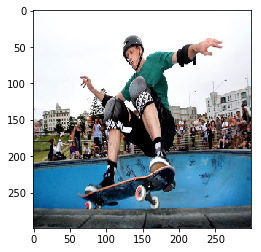

In [26]:
show_predictions('https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg')

a black cat is laying on a bed .
a cat is laying on a bed with a laptop .
a black and white cat laying on a bed .
a black and white cat sitting on a bed .
a cat is laying on a bed with a blanket .
a cat is sitting on a couch with a laptop .
a cat is laying on a bed with a laptop .
a cat is sitting on a bed with a laptop .
a cat is laying on a bed in a room .
a black and white cat sitting on a bed .


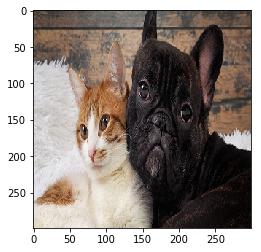

In [27]:
show_predictions('http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg')

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

a close up of a piece of cake with a fork
a close up of a glass of wine on a table
a close up of a small glass of wine .
a small white plate with a glass of wine
a close up of a glass of wine .
a close up of a cake with a knife
a close up of a white plate with a fork and a glass of beer
a small white plate topped with a glass of food .
a close up of a glass of wine
a close up of a piece of cake with a fork


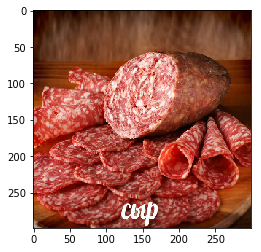

In [28]:
show_predictions('https://pbs.twimg.com/media/DNjl6SAX0AAaXzA?format=jpg')

a woman holding a cell phone in her hand .
a woman holding a cell phone in her hand .
a woman holding a cell phone in her hand .
a woman holding a cell phone in her hand .
a woman holding a cell phone in her hand .
a woman holding a white and blue and white tie .
a woman holding a cell phone in her hand .
a woman holding a white and white shirt and a blue and white tie .
a woman holding a cell phone in her hand .
a woman holding a pink and white and white tie .


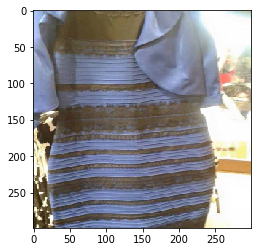

In [29]:
show_predictions('https://upload.wikimedia.org/wikipedia/ru/b/b3/TheDress.jpg')

a bird perched on a branch in the water .
a bird is sitting on a branch in the water .
a bird is standing on a tree branch .
a bird is sitting on a branch in the water .
a bird perched on a branch in the water .
a bird perched on a tree branch in the water .
a bird is standing on a tree branch .
a bird perched on a branch in the water .
a bird sitting on a branch in the water .
a bird that is standing in the water .


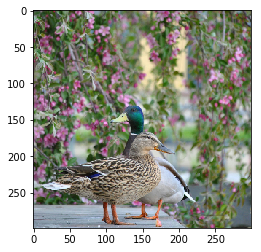

In [30]:
show_predictions('https://sun9-40.userapi.com/udEP4Vx4vWj3SO3RkWhyv6LRAjOH3dJSLV9VVQ/Aybj16XnLlQ.jpg')

a large building with a clock on the side of it .
a building with a clock on the side of it
a large building with a clock on the front of it .
a large building with a clock on the side of it .
a building with a clock on the side of it
a large building with a clock on the side of it .
a clock tower with a clock on the top of it .
a large building with a clock on the side of it
a clock tower with a clock on the front of it .
a clock tower with a clock on the top of it .


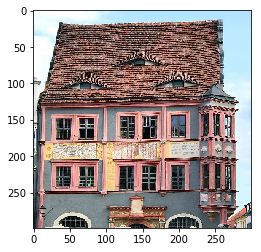

In [31]:
show_predictions('https://sun9-31.userapi.com/c858224/v858224056/13900e/jrOfuyr0-ZI.jpg')

a sign that is in the middle of a building
a sign that is in the middle of a building .
a sign on a wall with a sign on it
a sign that is in the middle of a building .
a sign with a sign that says " #UNK# " "
a sign that is in the middle of a building .
a sign that is in the middle of a building .
a sign that is in the middle of a building .
a sign that is in the middle of a building .
a sign that is in the middle of a building .


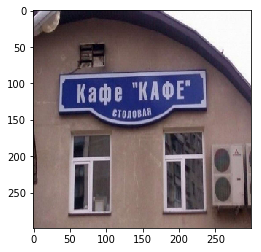

In [32]:
show_predictions('https://sun9-12.userapi.com/c853420/v853420884/210d21/OdnOY3QFj20.jpg')

a hot dog with a hot dog on it .
a hot dog with a pickle on it and a knife .
a hot dog with a bun on it .
a hot dog with a pickle on it .
a hot dog with mustard and a pickle on it .
a hot dog with a pickle on it .
a hot dog with a pickle on it .
a hot dog with mustard and onions on it .
a hot dog with mustard and mustard on it .
a hot dog with ketchup and a pickle on it .


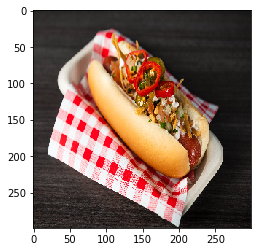

In [33]:
show_predictions('https://media.timeout.com/images/105419446/image.jpg')

a man with a hat and a hat on a leash .
a man holding a frisbee in his mouth .
a man with a hat is standing next to a banana .
a man with a hat on a skateboard
a man holding a frisbee in his hand .
a man holding a red and white frisbee .
a man with a hat on a skateboard .
a man holding a banana in his hand .
a man is holding a banana in the air .
a man holding a frisbee in his hand .


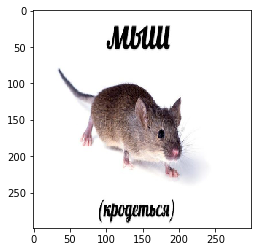

In [34]:
show_predictions('https://memepedia.ru/wp-content/uploads/2018/08/mi0-768x490.jpg')

a close up of a cat sitting on a bench .
a close up of a cat sitting on a bench .
a cat sitting on a wooden bench .
a cat sitting on a wooden bench .
a close up of a cat sitting on a bench .
a cat sitting on a chair next to a laptop .
a cat is sitting on a wooden bench .
a cat sitting on a wooden bench .
a close up of a cat sitting on a bench
a cat is sitting on a bench in front of a window .


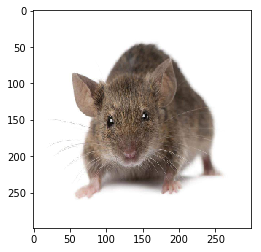

In [35]:
show_predictions('https://pbs.twimg.com/media/DOCm715VoAEJQPo.jpg:large')

a bird is sitting on a branch of a tree .
a bird sitting on a wooden bench in the water .
a cat is sitting on a bench in the grass .
a close up of a bird on a branch
a cat sitting on a bench next to a tree .
a bird is sitting on a wooden bench .
a bird is sitting on a branch in the grass .
a bird sitting on a wooden bench .
a bird sitting on a branch in the grass .
a brown and white bird sitting on a bench


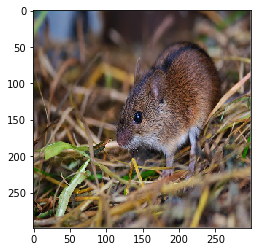

In [36]:
show_predictions('https://avatars.mds.yandex.net/get-pdb/963318/dd65308c-623f-4930-8cf0-ae7a0c7d4d68/s1200?webp=false')

a bird is standing in the grass with a tree .
a bird is standing on a tree branch in the grass .
a bird standing on a tree branch in a tree .
a bird standing on a tree branch in a tree .
a bird is standing in the grass with a tree .
a bird is standing in the grass with a tree .
a bird is standing in the grass near a tree .
a bird is standing in the grass with a tree .
a bird is standing in the grass next to a tree .
a bird is standing on a tree branch in the grass .


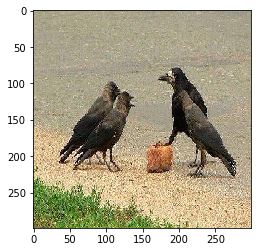

In [37]:
show_predictions('https://i.mycdn.me/i?r=AyH4iRPQ2q0otWIFepML2LxRYE8P5l_2C1mUdRnDe_rCRQ')

a group of people that are sitting on a bench .
a group of people sitting on a bench in front of a building .
a group of people sitting on a bench in front of a building .
a group of people sitting on a bench in front of a building .
a group of people sitting on a bench in front of a building .
a man is sitting on a bench in front of a building .
a group of people sitting on a bench in front of a building .
a group of people standing next to a man on a skateboard .
a group of people sitting on a bench in a park .
a group of people sitting on a bench in front of a building .


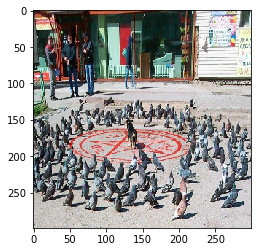

In [38]:
show_predictions('https://sun9-31.userapi.com/c846321/v846321800/17d6a2/Mq5CPLc3mRw.jpg')

a group of people are standing in the sand .
a group of people are standing on a beach .
a group of people are standing on a beach .
a group of people standing on a beach next to a surfboard .
a group of people are standing in the sand .
a group of people are standing in the water .
a group of people are standing in the sand .
a group of people are sitting on a beach .
a group of people are standing in the water .
a group of people that are standing in the grass .


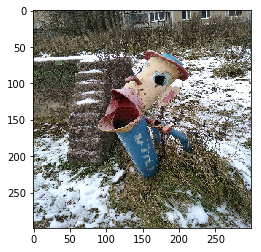

In [39]:
show_predictions('https://sun9-68.userapi.com/c841634/v841634848/3bf66/-4BP92A1Vyw.jpg')

a cat is sitting on a bench in the grass .
a cat is sitting on a wooden bench .
a cat is standing next to a tree .
a cat is standing next to a tree .
a cat is sitting on a wooden bench .
a cat sitting on a bench in a tree .
a cat is sitting on a bench in the grass .
a cat is sitting on a bench in the grass .
a cat sitting on a wooden bench near a tree .
a cat is standing next to a tree .


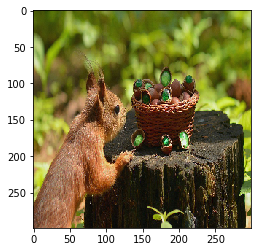

In [40]:
show_predictions('https://sun9-34.userapi.com/c626619/v626619167/2cc3c/8BFJbtpO1Co.jpg')